In [1]:
import tensorflow as tf
import os
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def limpiar_directorio(directorio):
    for filename in os.listdir(directorio):
        file_path = os.path.join(directorio, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

sample_size_percentage = 1

origen = r"C:/Users/Matias/Desktop/Tesis/dataset_consolidado"
destino = r"C:/Users/Matias/Desktop/Tesis/train_dataset"

limpiar_directorio(destino)

categorias = ['benigno', 'maligno']
for cat in categorias:
    os.makedirs(os.path.join(destino, 'train', cat), exist_ok=True)
    os.makedirs(os.path.join(destino, 'val', cat), exist_ok=True)
    os.makedirs(os.path.join(destino, 'test', cat), exist_ok=True)
    
    archivos = os.listdir(os.path.join(origen, cat))
    np.random.shuffle(archivos)
    archivos = archivos[:int(len(archivos) * sample_size_percentage)]

    train_val, test = train_test_split(archivos, test_size=0.2, random_state=42)
    train, val = train_test_split(train_val, test_size=0.25, random_state=42)
    
    for archivo in train:
        shutil.copy(os.path.join(origen, cat, archivo), os.path.join(destino, 'train', cat, archivo))
    for archivo in val:
        shutil.copy(os.path.join(origen, cat, archivo), os.path.join(destino, 'val', cat, archivo))
    for archivo in test:
        shutil.copy(os.path.join(origen, cat, archivo), os.path.join(destino, 'test', cat, archivo))

target_size = (256, 256)  # Nuevo tamaño de las imágenes

train_dir = os.path.join(destino, 'train')
val_dir = os.path.join(destino, 'val')
test_dir = os.path.join(destino, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=20, 
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=20,  
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=20,  
    class_mode='binary')



Found 27154 images belonging to 2 classes.
Found 9027 images belonging to 2 classes.
Found 9059 images belonging to 2 classes.


# Modelos diferenciados

In [4]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import pickle


def crear_dataframe(dataset_dir):
    subcarpetas = ['train', 'val', 'test']
    data = {'ruta': [], 'etiqueta': [], 'tipo': []}
    
    for subcarpeta in subcarpetas:
        for categoria in ['benigno', 'maligno']:
            dir_path = os.path.join(dataset_dir, subcarpeta, categoria)
            
            for filename in os.listdir(dir_path):
                parts = filename.split('_')
                
                # Verificar si el archivo es del tipo nuevo o del antiguo
                if len(parts) > 2 and (parts[0] == 'oral'):
                    # Formato nuevo: oral_benigno_Normal_400x_112_1_13
                    tipo_cancer = parts[0]  # 'oral'
                    etiqueta = parts[1]  # 'benigno' o 'maligno'
                    # No necesitamos concatenar el resto ya que solo queremos el tipo de cáncer y la etiqueta
                elif len(parts) == 3:
                    # Formato antiguo: colon_benigno_colonn3
                    tipo_cancer, etiqueta, _ = parts
                else:
                    print(f"Archivo {filename} ignorado por tener un formato incorrecto.")
                    continue  # Si no cumple con ninguno de los formatos esperados, ignorar este archivo
                
                ruta_completa = os.path.join(dir_path, filename)
                data['ruta'].append(ruta_completa)
                data['etiqueta'].append(etiqueta)  # Asegurarse de que 'etiqueta' corresponde a 'benigno' o 'maligno'
                data['tipo'].append(tipo_cancer)
    
    return pd.DataFrame(data)



def crear_generadores_por_tipo(df, tipo_cancer, target_size=(256, 256), batch_size=20):
    # Filtrar el DataFrame por el tipo de cáncer
    df_filtrado = df[df['tipo'] == tipo_cancer]
    
    # Crear el ImageDataGenerator para reescalado
    datagen = ImageDataGenerator(rescale=1./255)
    
    # Filtrar adicionalmente por datos de entrenamiento y validación
    df_train = df_filtrado[df_filtrado['ruta'].str.contains('train')]
    df_val = df_filtrado[df_filtrado['ruta'].str.contains('val')]
    
    # Crear el generador de entrenamiento
    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train,
        x_col='ruta',
        y_col='etiqueta',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # Asumiendo clasificación binaria
        shuffle=True  # Importante para el entrenamiento
    )
    
    # Crear el generador de validación
    validation_generator = datagen.flow_from_dataframe(
        dataframe=df_val,
        x_col='ruta',
        y_col='etiqueta',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # Asumiendo clasificación binaria
        shuffle=False  # No es necesario mezclar para validación
    )
    
    return train_generator, validation_generator


def crear_generador_test(df, tipo_cancer, target_size=(256, 256), batch_size=20):
    # Filtrar el DataFrame por el tipo de cáncer y que la ruta contenga 'test'
    df_test = df[(df['tipo'] == tipo_cancer) & (df['ruta'].str.contains('test'))]
    
    datagen = ImageDataGenerator(rescale=1./255)  # Reescalado de las imágenes
    
    # Crear el generador de test
    test_generator = datagen.flow_from_dataframe(
        dataframe=df_test,
        x_col='ruta',
        y_col='etiqueta',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # Asumiendo clasificación binaria
        shuffle=False  # No se mezcla para asegurar la correspondencia con las etiquetas
    )
    
    return test_generator






## Oscultacion Redes

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img


# Función para ocultar secciones de la imagen
def ocultar_seccion(imagen, top_left, tamano, valor_ocultacion=0.5):
    imagen_modificada = np.copy(imagen)
    x, y = top_left
    ancho, alto = tamano
    imagen_modificada[y:y+alto, x:x+ancho, :] = valor_ocultacion
    return imagen_modificada

# Función para visualizar la ocultación con predicción
def visualizar_ocultacion_con_prediccion(imagen, modelo, top_left, tamano_parche):
    imagen_oculta = ocultar_seccion(imagen, top_left, tamano_parche)
    prediccion = modelo.predict(np.expand_dims(imagen_oculta, axis=0))
    
    plt.figure(figsize=(6, 6))
    plt.imshow(imagen_oculta)
    plt.title(f"Predicción: {prediccion[0]}")
    plt.show()

    return prediccion


# Función para generar y mostrar el mapa de calor para una imagen
def generar_mostrar_mapa_calor(ruta_imagen, modelo, tamano_parche=32, paso=16):
    imagen = load_img(ruta_imagen, target_size=(256, 256))
    imagen_array = img_to_array(imagen) / 255.0
    mapa_calor = np.zeros((imagen_array.shape[0], imagen_array.shape[1]))

    # Predicción de la imagen original para comparar
    prediccion_original = modelo.predict(np.expand_dims(imagen_array, axis=0))[0][0]

    # Iterar sobre la imagen con un parche deslizante
    for y in range(0, imagen_array.shape[0] - tamano_parche, paso):
        for x in range(0, imagen_array.shape[1] - tamano_parche, paso):
            imagen_modificada = ocultar_seccion(imagen_array, (x, y), (tamano_parche, tamano_parche))
            prediccion_modificada = modelo.predict(np.expand_dims(imagen_modificada, axis=0))[0][0]
            cambio_prediccion = np.abs(prediccion_original - prediccion_modificada)
            mapa_calor[y:y+tamano_parche, x:x+tamano_parche] += cambio_prediccion

    # Normalizar el mapa de calor
    mapa_calor = mapa_calor / np.max(mapa_calor)

    # Visualizar el mapa de calor
    plt.figure(figsize=(10, 10))
    plt.imshow(imagen)
    plt.imshow(mapa_calor, cmap='jet', alpha=0.5)
    plt.title('Mapa de calor de la ocultación')
    plt.axis('off')
    plt.show()




## Modelo complejo

In [6]:
import numpy as np
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop

def crear_modelo(num_neuronas, dropout_rate, estructura_adicional=[]):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten()
    ])

    # Capa base densa
    model.add(Dense(num_neuronas, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    # Capas densas adicionales según estructura_adicional
    for neurons, drop in estructura_adicional:
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(drop))
    
    # Capa de salida
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

def optimizar_modelo(train_gen, val_gen, test_gen, tipo_cancer):
    mejor_test_acc = 0
    mejor_modelo = None
    mejor_historia = None
    mejor_hiperparams = {}

    for i in range(20):  # Número de iteraciones de búsqueda
        print('Vamos en la iteración', i+1)
        num_neuronas = np.random.choice([128, 256, 512, 1024, 2048])
        dropout_rate = np.random.choice([0, 0.3, 0.5, 0.7])
        estructura_adicional = [
            (np.random.choice([128, 256, 512, 1024, 2048]), np.random.choice([0, 0.3, 0.5, 0.7]))
            for _ in range(np.random.randint(0, 3))  # 0-2 capas adicionales
        ]
        learning_rates = np.random.choice([0.01, 0.001, 0.0001, 0.00001])
        optimizadores = np.random.choice(['adam', 'sgd', 'rmsprop'])

        model = crear_modelo(num_neuronas, dropout_rate, estructura_adicional)
        optimizer = {
            'adam': Adam(learning_rate=learning_rates),
            'sgd': SGD(learning_rate=learning_rates),
            'rmsprop': RMSprop(learning_rate=learning_rates)
        }[optimizadores]

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        print(f"Entrenando con {num_neuronas} neuronas, dropout de {dropout_rate}, tasa de aprendizaje {learning_rates}, y optimizador {optimizadores}")
        print(f"Estructura adicional: {estructura_adicional}")
        history = model.fit(train_gen, steps_per_epoch=100, epochs=10, validation_data=val_gen)

        test_loss, test_acc = model.evaluate(test_gen)
        print(f"Test Accuracy: {test_acc}")
        if test_acc > mejor_test_acc:
            mejor_test_acc = test_acc
            mejor_modelo = model
            mejor_historia = history.history
            mejor_hiperparams = {
                'neuronas': num_neuronas,
                'dropout': dropout_rate,
                'estructura_adicional': estructura_adicional,
                'learning_rate': learning_rates,
                'optimizador': optimizadores,
                'test_accuracy': test_acc
            }
    # Guardar el mejor modelo y su historial
    mejor_modelo.save(f'C:/Users/Matias/Desktop/Tesis/Tesis-Models/{tipo_cancer}_models/{tipo_cancer}_mejor_modelo_2.h5')
    with open(f'C:/Users/Matias/Desktop/Tesis/Tesis-Models/{tipo_cancer}_models/{tipo_cancer}_mejor_historia_2.pickle', 'wb') as f:
        pickle.dump(mejor_historia, f)
    
    print("Mejor configuración encontrada:")
    print(mejor_hiperparams)

    return mejor_modelo, mejor_historia



## Creacion df

In [7]:
dataset_dir = r"C:/Users/Matias/Desktop/Tesis/train_dataset"
df = crear_dataframe(dataset_dir)
df

,ruta,etiqueta,tipo
0,C:/Users/Matias/Desktop/Tesis/train_dataset\tr...,benigno,colon
1,C:/Users/Matias/Desktop/Tesis/train_dataset\tr...,benigno,colon
2,C:/Users/Matias/Desktop/Tesis/train_dataset\tr...,benigno,colon
3,C:/Users/Matias/Desktop/Tesis/train_dataset\tr...,benigno,colon
4,C:/Users/Matias/Desktop/Tesis/train_dataset\tr...,benigno,colon
...,...,...,...
46459,C:/Users/Matias/Desktop/Tesis/train_dataset\te...,maligno,oral
46460,C:/Users/Matias/Desktop/Tesis/train_dataset\te...,maligno,oral
46461,C:/Users/Matias/Desktop/Tesis/train_dataset\te...,maligno,oral
46462,C:/Users/Matias/Desktop/Tesis/train_dataset\te...,maligno,oral


In [8]:
# Encuentra los tipos únicos de cáncer en el DataFrame
tipos_cancer = df['tipo'].unique()
print(tipos_cancer)

['colon' 'gastrointestinal' 'lung' 'oral']


# Modelos Colon

In [9]:
print(f"Entrenando y guardando modelos para {'colon'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'colon')

test_generator = crear_generador_test(df, 'colon', target_size=(256, 256), batch_size=20)
# Modelo complejo
modelo_complejo, historia_complejo = optimizar_modelo(train_gen, val_gen, test_generator, 'colon')




Entrenando y guardando modelos para colon...
Found 10000 validated image filenames belonging to 2 classes.
Found 2023 validated image filenames belonging to 2 classes.
Found 1962 validated image filenames belonging to 2 classes.
Vamos en la iteración 1


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Entrenando con 2048 neuronas, dropout de 0.5, tasa de aprendizaje 0.01, y optimizador sgd
Estructura adicional: [(1024, 0.0)]
Epoch 1/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 521ms/step - accuracy: 0.4894 - loss: 0.6948 - val_accuracy: 0.5161 - val_loss: 0.6918
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 508ms/step - accuracy: 0.5339 - loss: 0.6911 - val_accuracy: 0.5161 - val_loss: 0.6890
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 500ms/step - accuracy: 0.5328 - loss: 0.6908 - val_accuracy: 0.7499 - val_loss: 0.6765
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 49s 495ms/step - accuracy: 0.5521 - loss: 0.6847 - val_accuracy: 0.6886 - val_loss: 0.6659
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 544ms/step - accuracy: 0.5655 - loss: 0.6822 - val_accuracy: 0.7637 - val_loss: 0.6477
Epoch 6/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7637 - val_loss: 0.6477
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 518ms/step - accuracy: 0.5701 - loss: 0.6757 - val_accuracy: 0.5615 - val_loss: 0.6741
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 542ms/step - accuracy: 0.5796 - loss: 0.6645 - val_accuracy: 0.4928 - val_loss: 0.6656
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 530ms/step - accuracy: 0.6338 - loss: 0.6538 - val_accuracy: 0.7350 - val_loss: 0.5996
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6376 - loss: 0.6392

# Modelos Lung

In [ ]:
print(f"Entrenando y guardando modelos para {'lung'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'lung')

test_generator = crear_generador_test(df, 'lung', target_size=(256, 256), batch_size=20)
# Modelo complejo
modelo_complejo, historia_complejo = optimizar_modelo(train_gen, val_gen, test_generator, 'lung')





Entrenando y guardando modelos para lung...
Found 15000 validated image filenames belonging to 2 classes.
Found 3016 validated image filenames belonging to 2 classes.
Found 3027 validated image filenames belonging to 2 classes.
Vamos en la iteración 1


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Entrenando con 256 neuronas, dropout de 0.0, tasa de aprendizaje 0.0001, y optimizador sgd
Epoch 1/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6350 - loss: 0.6866 - val_accuracy: 0.6747 - val_loss: 0.6769
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 95s 950ms/step - accuracy: 0.6718 - loss: 0.6740 - val_accuracy: 0.6747 - val_loss: 0.6628
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 888ms/step - accuracy: 0.6693 - loss: 0.6634 - val_accuracy: 0.6747 - val_loss: 0.6533
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 88s 883ms/step - accuracy: 0.6721 - loss: 0.6583 - val_accuracy: 0.6747 - val_loss: 0.6471
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 852ms/step - accuracy: 0.6759 - loss: 0.6518 - val_accuracy: 0.6747 - val_loss: 0.6415
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 867ms/step - accuracy: 0.6584 - loss: 0.6517 - val_accuracy: 0.6747 - val_loss: 0.6366
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 853ms/step - accuracy: 0.6523 - loss: 0.6477 - val_accuracy: 0.6747 - val_loss: 0.6324
Epoch 8/10
 50/100 ━━━━━━━━━━━━━━━━━━━━ 28s 562ms/step - accuracy: 0.6731 - loss: 0.6388

c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 537ms/step - accuracy: 0.6735 - loss: 0.6315 - val_accuracy: 0.6747 - val_loss: 0.6297
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 844ms/step - accuracy: 0.6697 - loss: 0.6374 - val_accuracy: 0.6747 - val_loss: 0.6250
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 840ms/step - accuracy: 0.6922 - loss: 0.6276 - val_accuracy: 0.6747 - val_loss: 0.6197
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 240ms/step - accuracy: 0.2934 - loss: 0.7876
Test Accuracy: 0.6544433236122131
Vamos en la iteración 2
Entrenando con 1024 neuronas, dropout de 0.7, tasa de aprendizaje 0.0001, y optimizador adam
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.7071 - loss: 0.5866 - val_accuracy: 0.9771 - val_loss: 0.0827
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.9782 - loss: 0.0914 - val_accuracy: 0.9781 - val_loss: 0.0940
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9758 - loss: 0.0912 - val_accuracy: 0.9794 - val_loss: 0.1041
E

Test Accuracy: 0.6544433236122131
Mejor configuración encontrada:
{'neuronas': 256, 'dropout': 0.5, 'estructura_adicional': [(512, 0.5)], 'learning_rate': 0.001, 'optimizador': 'rmsprop', 'test_accuracy': 0.9904195666313171}


# Gastrointestinal

In [ ]:
print(f"Entrenando y guardando modelos para {'gastrointestinal'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'gastrointestinal')

test_generator = crear_generador_test(df, 'gastrointestinal', target_size=(256, 256), batch_size=20)
# Modelo complejo
modelo_complejo, historia_complejo = optimizar_modelo(train_gen, val_gen, test_generator, 'gastrointestinal')




Entrenando y guardando modelos para gastrointestinal...
Found 8000 validated image filenames belonging to 2 classes.
Found 1575 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.
Vamos en la iteración 1


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Entrenando con 512 neuronas, dropout de 0.0, tasa de aprendizaje 0.001, y optimizador adam
Estructura adicional: [(512, 0.7)]
Epoch 1/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.5371 - loss: 0.9450 - val_accuracy: 0.4889 - val_loss: 0.6932
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 95s 947ms/step - accuracy: 0.5043 - loss: 0.6930 - val_accuracy: 0.5111 - val_loss: 0.6929
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 939ms/step - accuracy: 0.5374 - loss: 0.6865 - val_accuracy: 0.4660 - val_loss: 0.6938
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 943ms/step - accuracy: 0.5263 - loss: 0.6924 - val_accuracy: 0.4946 - val_loss: 0.6857
Epoch 5/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4946 - val_loss: 0.6857
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 95s 939ms/step - accuracy: 0.6851 - loss: 0.5983 - val_accuracy: 0.8508 - val_loss: 0.4245
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 935ms/step - accuracy: 0.8788 - loss: 0.2965 - val_accuracy: 0.8432 - val_loss: 0.4877
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 937ms/step - accuracy: 0.8639 - loss: 0.2995 - val_accuracy: 0.9429 - val_loss: 0.1996
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 932ms/step - accuracy: 0.8924 - loss: 0.2492 - val_accuracy: 0.8013 - val_loss: 0.2952
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8013 - val_loss: 0.2952
400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 162ms/step - accuracy: 0.7333 - loss: 0.3901
Test Accuracy: 0.8080000281333923
Vamos en la iteración 2
Entrenando con 512 neuronas, dropout de 0.3, tasa de aprendizaje 0.001, 

Test Accuracy: 0.934249997138977
Mejor configuración encontrada:
{'neuronas': 256, 'dropout': 0.5, 'estructura_adicional': [], 'learning_rate': 0.0001, 'optimizador': 'adam', 'test_accuracy': 0.9513750076293945}


# Oral

In [ ]:
print(f"Entrenando y guardando modelos para {'oral'}...")
train_gen, val_gen = crear_generadores_por_tipo(df, 'oral')

test_generator = crear_generador_test(df, 'oral', target_size=(256, 256), batch_size=20)
# Modelo complejo
modelo_complejo, historia_complejo = optimizar_modelo(train_gen, val_gen, test_generator, 'oral')



Entrenando y guardando modelos para oral...
Found 12240 validated image filenames belonging to 2 classes.
Found 2432 validated image filenames belonging to 2 classes.
Found 2449 validated image filenames belonging to 2 classes.
Vamos en la iteración 1


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Entrenando con 1024 neuronas, dropout de 0.5, tasa de aprendizaje 0.001, y optimizador sgd
Estructura adicional: [(256, 0.5), (256, 0.5)]
Epoch 1/10


c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7259 - loss: 0.6366 - val_accuracy: 0.7755 - val_loss: 0.5564
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.7564 - loss: 0.5913 - val_accuracy: 0.7755 - val_loss: 0.5555
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.7750 - loss: 0.5644 - val_accuracy: 0.7755 - val_loss: 0.5487
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.7621 - loss: 0.5738 - val_accuracy: 0.7755 - val_loss: 0.5502
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7630 - loss: 0.5817 - val_accuracy: 0.7755 - val_loss: 0.5500
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7616 - loss: 0.5698 - val_accuracy: 0.7755 - val_loss: 0.5505
Epoch 7/10
 12/100 ━━━━━━━━━━━━━━━━━━━━ 1:07 765ms/step - accuracy: 0.7741 - loss: 0.5880

c:\Users\Matias\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 332ms/step - accuracy: 0.7566 - loss: 0.5476 - val_accuracy: 0.7755 - val_loss: 0.5505
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.7776 - loss: 0.5601 - val_accuracy: 0.7755 - val_loss: 0.5499
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7635 - loss: 0.5737 - val_accuracy: 0.7755 - val_loss: 0.5503
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7739 - loss: 0.5556 - val_accuracy: 0.7755 - val_loss: 0.5464
123/123 ━━━━━━━━━━━━━━━━━━━━ 33s 267ms/step - accuracy: 0.4276 - loss: 0.9263
Test Accuracy: 0.7619436383247375
Vamos en la iteración 2
Entrenando con 512 neuronas, dropout de 0.3, tasa de aprendizaje 0.001, y optimizador rmsprop
Estructura adicional: [(512, 0.5), (128, 0.3)]
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.6936 - loss: 0.6785 - val_accuracy: 0.7755 - val_loss: 0.5133
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.7770 - loss: 0.5619

Test Accuracy: 0.7721518874168396
Mejor configuración encontrada:
{'neuronas': 512, 'dropout': 0.5, 'estructura_adicional': [(256, 0.5), (128, 0.0)], 'learning_rate': 0.0001, 'optimizador': 'adam', 'test_accuracy': 0.7721518874168396}


In [ ]:
import matplotlib.pyplot as plt

def visualizar_historial(historia):
    acc = historia['accuracy']
    val_acc = historia['val_accuracy']
    loss = historia['loss']
    val_loss = historia['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'bo', label='Precisión de entrenamiento')
    plt.plot(epochs, val_acc, 'b', label='Precisión de validación')
    plt.title('Precisión de Entrenamiento y Validación')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
    plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.legend()

    plt.show()


In [ ]:
def cargar_historial(tipo_cancer):
    with open(f'C:/Users/Matias/Desktop/Tesis/Tesis-Models/{tipo_cancer}_models/{tipo_cancer}_mejor_historia.pickle', 'rb') as f:
        history = pickle.load(f)
    return history




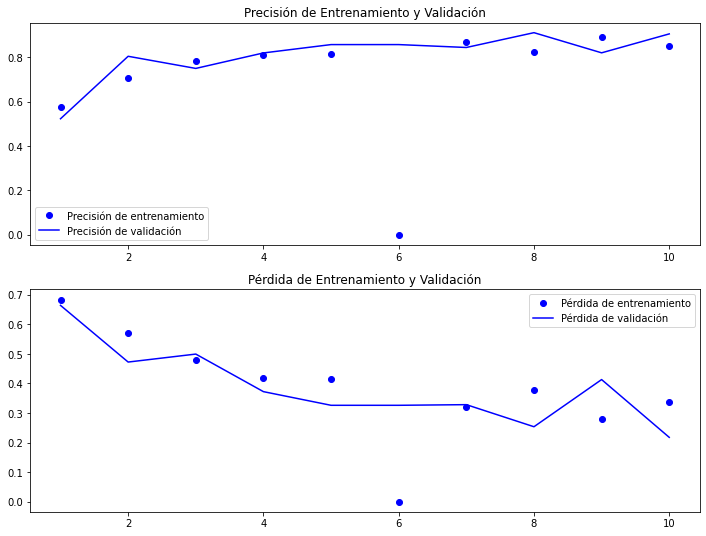

In [ ]:
historia = cargar_historial('colon')
visualizar_historial(historia)


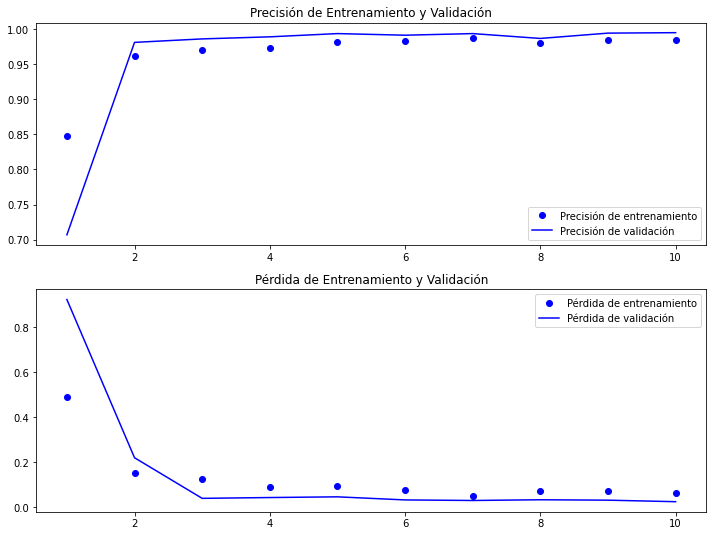

In [ ]:
historia = cargar_historial('lung')
visualizar_historial(historia)


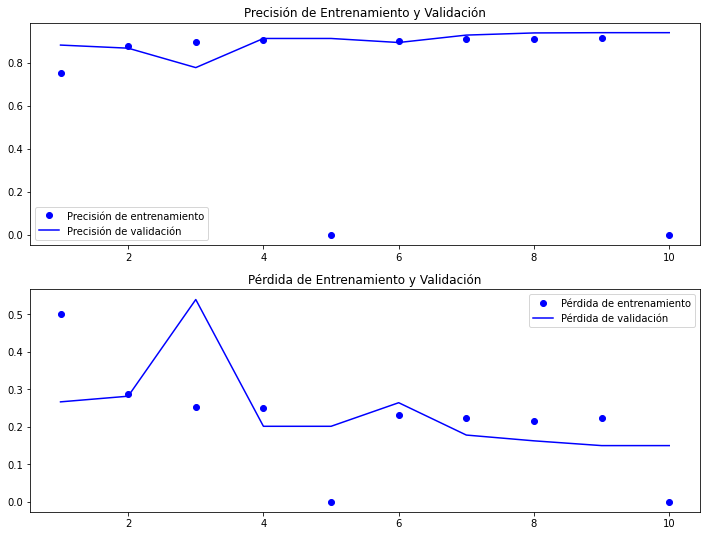

In [ ]:
historia = cargar_historial('gastrointestinal')
visualizar_historial(historia)

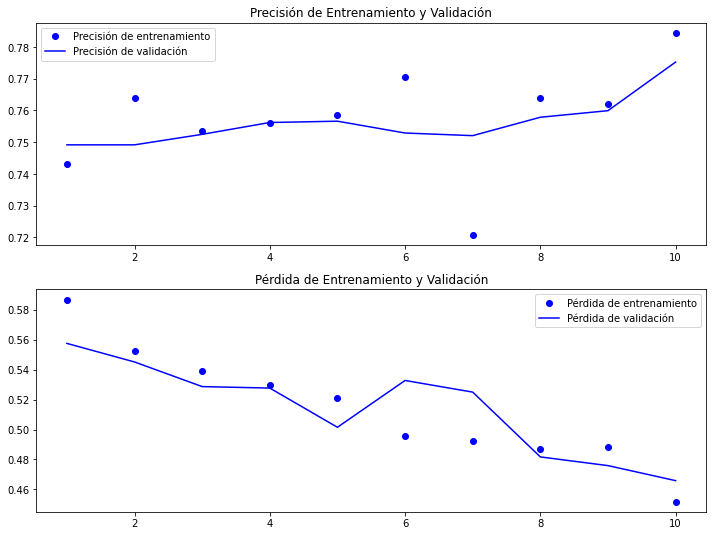

In [ ]:
historia = cargar_historial('oral')
visualizar_historial(historia)